# Forecasting CNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024
Updated: 03/17/2025

This script performs the following tasks:

1. Loads the database containing processed CFS forecast data.
2. Passes the forecast data through the trained model(s).
3. Generates an ensemble of CNBS forecasts for each of the Great Lakes.
4. Saves the forecasts to a database and/or CSV file.
5. Creates a figure with time series plots and exports it as a PNG file.

The script requires the following files:
- cfs_forecast_data.db
- x_scaler.joblib
- y_scaler.joblib

And at least one or more of the following trained models:
- GP_trained_model.joblib
- RF_trained_model.joblib
- LR_trained_model.joblib
- NN_trained_model.joblib

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os
import sys
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [18]:
# Add the path to the src directory (two levels up)
sys.path.append(os.path.abspath('../../'))
from src.data_processing import filter_predictions, predict_cnbs, add_df_to_db
from src.hydro_utils import convert_mm_to_cms

# User Input

In [19]:
# Directory where the repository is cloned
local_path = '/Users/ljob/Desktop/'

# Path to data directory
dir = local_path + 'cnbs-predictor/data/'

# Path to input CFS forecast database
cfs_database = local_path + 'cfs_forecast_data.db'

# Path to save CNBS forecast output to a database
cnbs_database = dir + 'forecast/cnbs_forecast.db'

# Path to saved scalers
x_scaler = dir + 'input/x_scaler.joblib'
y_scaler = dir + 'input/y_scaler.joblib'

# Define directory to trained models to use along with their paths
models_info = [{'model': 'GP', 'path': dir + 'input/GP_trained_model.joblib'},
               {'model': 'RF', 'path': dir + 'input/RF_trained_model.joblib'},
               {'model': 'LR', 'path': dir + 'input/LR_trained_model.joblib'},
               {'model': 'NN', 'path': dir + 'input/NN_trained_model.joblib'}]

# Begin Script

In [20]:
# Create a connection to the SQLite database
conn = sqlite3.connect(cfs_database)

# Define the query to get all the data
query = '''
SELECT * FROM cfs_forecast_data
'''

# Execute the query and fetch the data into a DataFrame
data = pd.read_sql(query, conn)

# Close the connection once done
conn.close()

data.set_index(['cfs_run', 'month', 'year'], drop=True, inplace=True)

In [21]:
# This creates 1 column with a variable name that combines column names from the database
# It just makes it simplier for the moment to call the data
data['variable'] = data['lake'] + '_' + data['surface_type'] + '_' + data['component']

In [22]:
# The variable names based on the above step in the order that they need to be in based on the order of variables during the training step
variables = ['superior_lake_precipitation', 'erie_lake_precipitation', 'ontario_lake_precipitation', 'michigan-huron_lake_precipitation', 
             'superior_land_precipitation', 'erie_land_precipitation', 'ontario_land_precipitation', 'michigan-huron_land_precipitation', 
             'superior_lake_evaporation', 'erie_lake_evaporation', 'ontario_lake_evaporation', 'michigan-huron_lake_evaporation',
             'superior_land_evaporation', 'erie_land_evaporation', 'ontario_land_evaporation', 'michigan-huron_land_evaporation',
             'superior_lake_air_temperature', 'erie_lake_air_temperature', 'ontario_lake_air_temperature', 'michigan-huron_lake_air_temperature', 
             'superior_land_air_temperature', 'erie_land_air_temperature', 'ontario_land_air_temperature', 'michigan-huron_land_air_temperature'
             ]  + [f'month_{i}' for i in range(1, 13)]

data = data.reset_index()
X = data.pivot_table(index=['cfs_run', 'year', 'month'], columns='variable', values='value [mm]')
# Remove column level name
X.columns.name = None

# Extract month from index and one-hot encode
X['month'] = X.index.get_level_values('month')
X = pd.get_dummies(X, columns=['month'], prefix='month')

# Ensure all month columns exist
for i in range(1, 13):
    col = f'month_{i}'
    if col not in X.columns:
        X[col] = 0

# Reorder columns to match training order
X = X[variables]

# For any reason, in a worse case scenario and there are NaNs (which there would never ever be missing data), drop the rows that include them
# Check first to see if there are NaN values in the DataFrame
if X.isna().any().any():
    print("NaNs were found in the input dataset. Details below:\n")

    # Optional: Show row indices with any NaNs
    print("\nRows with NaNs:")
    print(X[X.isna().any(axis=1)])

    print("\nRemoving rows with NaN values before continuing.\n")
    X = X.dropna(how='any')

In [23]:
# This removes any old cfs forecasts that we do not need cnbs forecasts for (such as forecasts for months that have passed). 
X_filtered = filter_predictions(X)

First month forecast: 5


Run CFS data through the trained models

In [24]:
# Initialize an empty dataframe to store predictions by model name
model_predictions = []

# Process each model and add to DB
for model_info in models_info:
    model_name = model_info['model']
    df_y = predict_cnbs(X_filtered, x_scaler, y_scaler, models_info, model_name)
    if df_y is not None:
        # Store the predictions in the dataframe
        df_y['model'] = model_name
        model_predictions.append(df_y)

df = pd.concat(model_predictions, ignore_index=False).reset_index()


202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


Format the CNBS forecasts, calculate values from mm to cms and add data to a database

In [25]:
# Format the data so it is organized and ready to add to the database
melt_df = df.melt(id_vars=['model', 'cfs_run', 'month', 'year'], var_name='lake_cnbs', value_name='value [mm]')
melt_df[['lake', 'component']] = melt_df['lake_cnbs'].str.split('_', expand=True)
melt_df_formatted = melt_df.drop(columns=['lake_cnbs']).loc[:, ['cfs_run', 'month', 'year', 'model', 'lake', 'component', 'value [mm]']]
melt_df_formatted = melt_df_formatted.sort_values(by=['cfs_run', 'month', 'year', 'model', 'lake']).set_index(['cfs_run', 'month', 'year'])
df_all = convert_mm_to_cms(melt_df_formatted)
add_df_to_db(cnbs_database, 'cnbs_forecast', df_all)

Calculate the mean of each month forecast by model

In [26]:
df_y_model_mean = df_all.groupby(['year', 'month', 'model', 'lake', 'component'])[['value [mm]', 'value [cms]']].mean().round(3)
add_df_to_db(cnbs_database, 'cnbs_forecast_model_mean', df_y_model_mean)

Calculate the mean of each month from all the model ensemble forecasts

In [27]:
# Get the mean value for each forecast month
df_y_mean = df_all.groupby(['year', 'month', 'lake', 'component'])[['value [mm]', 'value [cms]']].mean().round(3).reset_index()

# Rename columns
df_y_mean.rename(columns={'year': 'forecast_year', 'month': 'forecast_month'}, inplace=True)

# Set a "current year" and "current month" to make tracking the forecast easier
df_y_mean['current_year'] = df_y_mean['forecast_year'][0]
df_y_mean['current_month'] = df_y_mean['forecast_month'][0]

# Only keep the columns we need and in a particulat order
df_y_mean = df_y_mean[['current_year', 'current_month', 'forecast_year', 'forecast_month', 'lake', 'component', 'value [mm]', 'value [cms]']]

# Save to a CSV [mm]
df_y_mean.to_csv(f'{dir}forecast/CNBS_forecast.csv', sep='\t', index=False)

In [28]:
# Create a column that is forecast date in YYYY_MM. This will just make is easier to pivot the table
df_y_mean['forecast'] = df_y_mean['forecast_year'].astype(str) + '_' + df_y_mean['forecast_month'].astype(str).str.zfill(2)

# Make sure they are sorted by the forecast date
df_test = df_y_mean.sort_values(['current_year', 'current_month', 'lake', 'forecast'])

# Pivot the table so the forecast date is in columns instead of rows
df_pivoted = df_test.pivot_table(
    index=['current_year', 'current_month', 'lake', 'component'],
    columns='forecast',
    values='value [cms]'
    ).reset_index()
df_pivoted.columns.name = None

In [29]:
# Get the forecast columns
forecast_cols = df_pivoted.columns.difference(['current_year', 'current_month', 'lake', 'component'])

# Sort the data
forecast_cols_sorted = sorted(forecast_cols)

# Rename columns to month_1, month_2, ...
rename_dict = {old: f'month_{i+1}' for i, old in enumerate(forecast_cols_sorted)}
df_pivoted = df_pivoted.rename(columns=rename_dict)

Plot the forecasts for each component for each lake by model output

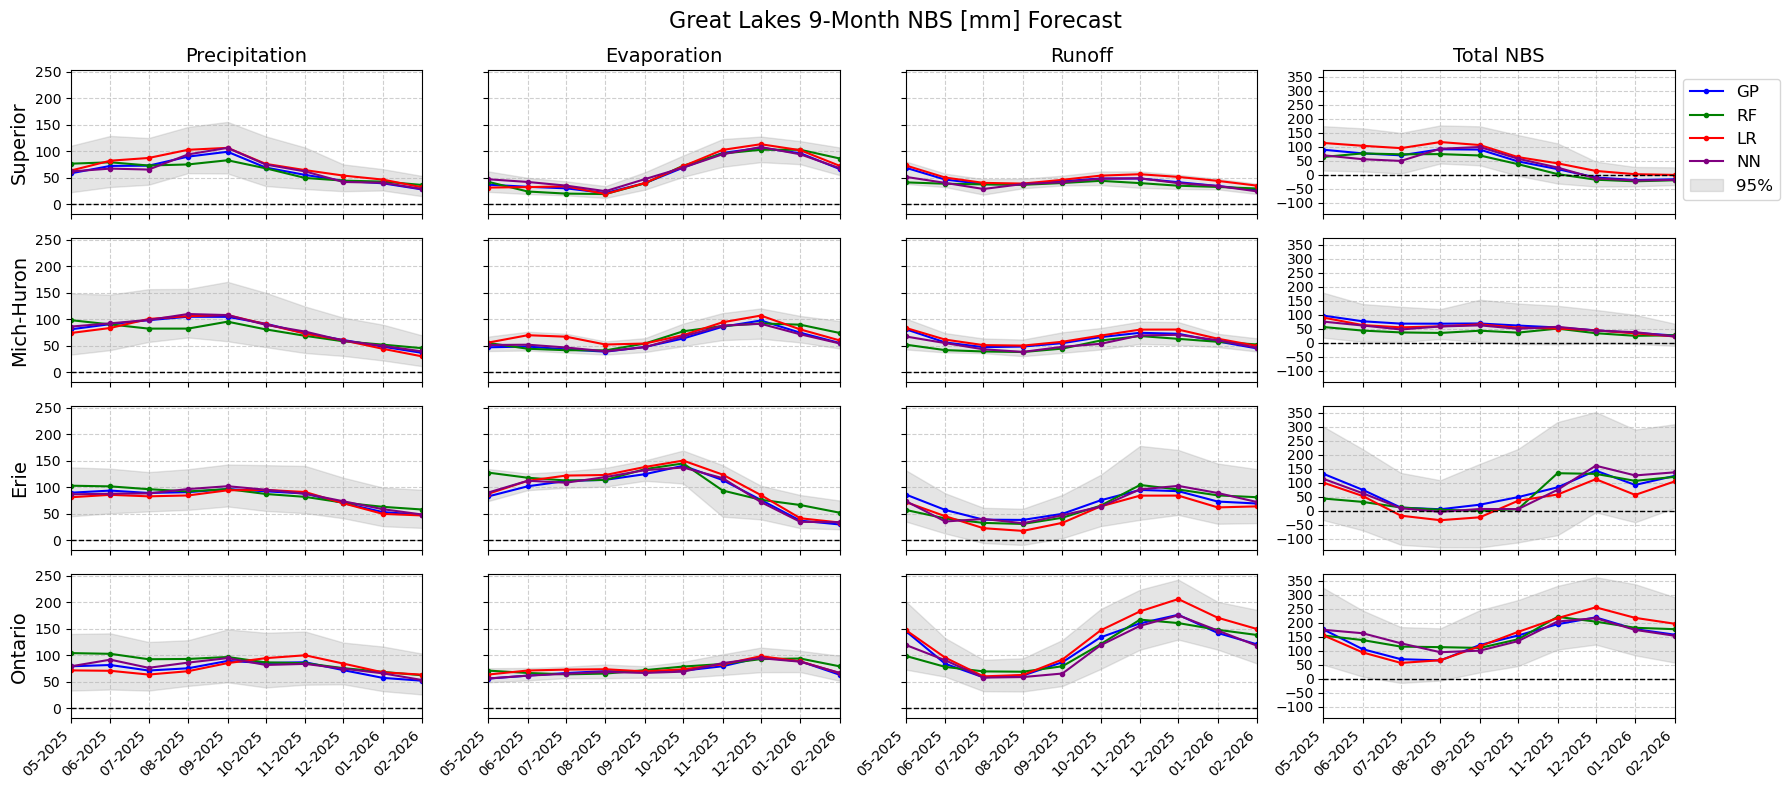

In [30]:
# Define model colors
model_colors = {
    'GP': 'blue',
    'RF': 'green',
    'LR': 'red',
    'NN': 'purple'
}

# Columns of interest in the order we want to plot them
columns = [
    'superior_precipitation', 'superior_evaporation', 'superior_runoff', 'superior_cnbs',
    'michigan-huron_precipitation', 'michigan-huron_evaporation', 'michigan-huron_runoff', 'michigan-huron_cnbs',
    'erie_precipitation', 'erie_evaporation', 'erie_runoff', 'erie_cnbs',
    'ontario_precipitation', 'ontario_evaporation', 'ontario_runoff', 'ontario_cnbs'
    ]

# Create a 4x4 subplot grid
fig, axs = plt.subplots(4, 4, figsize=(18, 8))

# Shared y-limits for columns 0–2
shared_y_min, shared_y_max = float('inf'), float('-inf')

# Separate y-limits for column 3 (NBS)
col4_y_min, col4_y_max = float('inf'), float('-inf')

# Loop over all the columns and plot
for i, column in enumerate(columns):
    row = i // 4
    col = i % 4

    # Determine the lower and upper bounds (confidence intervals)
    lower_bound = df.groupby(['year', 'month'])[column].quantile(0.025).reset_index()
    upper_bound = df.groupby(['year', 'month'])[column].quantile(0.975).reset_index()

    for model_info in models_info:
        model_name = model_info['model']
        model_mean = df[df['model'] == model_name]
        mean_df = model_mean.groupby(['year', 'month']).mean(numeric_only=True).reset_index()
        mean_df['date'] = pd.to_datetime(mean_df[['year', 'month']].assign(day=1))

        axs[row, col].plot(mean_df['date'], mean_df[column], marker='o', markersize=3,
                           color=model_colors[model_name], label=model_name)

    axs[row, col].fill_between(mean_df['date'], lower_bound[column], upper_bound[column],
                               color='gray', alpha=0.2, label = '95%')

    axs[row, col].axhline(0, color='black', linestyle='--', linewidth=1)
    axs[row, col].grid(True, linestyle='--', alpha=0.6)
    axs[row, col].set_yticks(np.arange(-1000, 1000, 50))

    # Track y-axis limits
    current_y_min = lower_bound[column].min()
    current_y_max = upper_bound[column].max()

    if col < 3:
        shared_y_min = min(shared_y_min, current_y_min)
        shared_y_max = max(shared_y_max, current_y_max)
    else:
        col4_y_min = min(col4_y_min, current_y_min)
        col4_y_max = max(col4_y_max, current_y_max)

    # Titles
    if row == 0:
        axs[row, col].set_title(['Precipitation', 'Evaporation', 'Runoff', 'Total NBS'][col], fontsize=14)

    # X-axis formatting
    if row == 3:
        axs[row, col].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%Y'))
        axs[row, col].tick_params(axis='x', rotation=45)
        for label in axs[row, col].get_xticklabels():
            label.set_horizontalalignment('right')
    else:
        axs[row, col].set_xticklabels([])

    # Y-axis labels
    if col == 0:
        axs[row, col].set_ylabel(['Superior', 'Mich-Huron', 'Erie', 'Ontario'][row], fontsize=14)
    elif col == 3:
        axs[row, col].set_ylabel(['', '', '', ''][row], fontsize=14)
    else:
        axs[row, col].set_yticklabels([])

# Apply y-axis limits
for row in range(4):
    for col in range(4):
        if col < 3:
            axs[row, col].set_ylim(shared_y_min - 10, shared_y_max + 10)
        else:
            axs[row, col].set_ylim(col4_y_min - 10, col4_y_max + 10)

        axs[row, col].set_xlim(mean_df['date'].iloc[0], mean_df['date'].iloc[-1])

fig.suptitle('Great Lakes 9-Month NBS [mm] Forecast', fontsize=16)

# Add legend
axs[0, 3].legend(loc='lower left', bbox_to_anchor=(1, 0.04), fontsize=12)

# Save and show
plt.savefig(f'{dir}forecast/CNBS_forecasts.png')
plt.tight_layout()
plt.show()


Create an interactive figure that will let you hover over lines and it shows the model and value. This saves as an html file and opens in a web browser.

In [31]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Define the colors for each model
model_colors = {
    'GP': 'blue',
    'RF': 'green',
    'LR': 'red',
    'NN': 'purple'
}

# Columns of interest in the order we want to plot them
columns = [
    'superior_precipitation', 'superior_evaporation', 'superior_runoff', 'superior_cnbs',
    'michigan-huron_precipitation', 'michigan-huron_evaporation', 'michigan-huron_runoff', 'michigan-huron_cnbs',
    'erie_precipitation', 'erie_evaporation', 'erie_runoff', 'erie_cnbs',
    'ontario_precipitation', 'ontario_evaporation', 'ontario_runoff', 'ontario_cnbs'
    ]

# Create a 1x4 subplot grid
fig = make_subplots(rows=4, cols=4, 
                    subplot_titles=['Precipitation', 'Evaporation', 'Runoff', 'CNBS'], 
                    shared_xaxes=True, shared_yaxes=True, vertical_spacing=0.05, horizontal_spacing=0.008)

global_y_min, global_y_max = float('inf'), float('-inf')  # Initialize to extremes

# Loop over the columns and plot the means for each dataset
for i, column in enumerate(columns):
    row = i // 4  # Row index
    col = i % 4   # Column index

# Determine the lower and upper bounds of all the model forecast
    lower_bound = df.groupby(['year', 'month'])[column].quantile(0.025).reset_index()
    upper_bound = df.groupby(['year', 'month'])[column].quantile(0.975).reset_index()

    for model_info in models_info:
        model_name = model_info['model']

        # Pull out the mean values for each model
        model_mean = df[df['model'] == model_name]

        # Get the grouped DataFrame for the current model
        mean_df = model_mean.groupby(['year', 'month']).mean(numeric_only=True).reset_index()
        
        mean_df['date'] = pd.to_datetime(mean_df[['year', 'month']].assign(day=1))

        # Add the shaded region (confidence band)
        fig.add_trace(go.Scatter(x=pd.concat([mean_df['date'], mean_df['date'][::-1]]),
                         y=pd.concat([lower_bound[column], upper_bound[column][::-1]]),
                         fill='toself', fillcolor='rgba(169, 169, 169, 0.2)',
                         line=dict(color='rgba(255,255,255,0)'), showlegend=False, 
                         hovertemplate='Date: %{x}<br>Conf: 95%<br>Value: %{y}'), 
                         row=row+1, col=col+1)
        
        # Add the mean line for the current model to the figure
        fig.add_trace(go.Scatter(x=mean_df['date'], y=mean_df[column],
                                 mode='lines+markers', name=model_name, 
                                 line=dict(shape='linear', width=2, color=model_colors[model_name]), 
                                 marker=dict(size=4), 
                                 showlegend=(row == 0 and col == 0),  # Only show legend for the first subplot
                                 hovertemplate='Date: %{x}<br>Value: %{y}<br>Model: ' + model_name),
                                 row=row+1, col=col+1)

        # Update global y-axis limits
        current_y_min = lower_bound[column].min()
        current_y_max = upper_bound[column].max()
        global_y_min = min(global_y_min, current_y_min)
        global_y_max = max(global_y_max, current_y_max)

    # Set x-axis range (limits) for each subplot
    #fig.update_xaxes(range=[mean_df['date'].iloc[0], mean_df['date'].iloc[-1]], row=row+1, col=col+1)

    # Format x-axis for the last row (set x-tick labels)
    if row == 3:
        fig.update_xaxes(tickformat='%m-%Y', tickangle=-45, row=row+1, col=col+1, tickmode='array', tickvals=mean_df['date'])
    else:
        fig.update_xaxes(showticklabels=False, row=row+1, col=col+1, tickmode='array', tickvals=mean_df['date'])

    # Set y-axis labels for the first column only
    if col == 0:
        fig.update_yaxes(title_text=['Superior', 'Mich-Huron', 'Erie', 'Ontario'][row], row=row+1, col=col+1)

    # Add the y=0 dashed line to every subplot
    fig.add_trace(go.Scatter(x=[mean_df['date'].min(), mean_df['date'].max()],
                             y=[0, 0], mode='lines', line=dict(color='black'), 
                             showlegend=False), row=row+1, col=col+1)

    # Add a box around each subplot
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', row=row+1, col=col+1)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', row=row+1, col=col+1)
    
# Set consistent y-axis limits across all subplots
for row in range(1, 5):
    for col in range(1, 5):
        fig.update_yaxes(range=[global_y_min - 10, global_y_max + 10], row=row+1, col=col+1)

# Set grid lines for all subplots
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='LightGray')
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='LightGray')

# Update layout and titles
fig.update_layout(
    title_text="Great Lakes 9-month NBS Forecasts",
    title_x=0.5,
    height=800, width=1500,
    showlegend=True,
    legend=dict(x=1.01, y=1.01, traceorder='normal', orientation='v', title='Model'),  # Move legend up
    plot_bgcolor='white',
)

# Save the figure as an interactive HTML file
fig.write_html(f'{dir}forecast/CNBS_forecasts_interactive.html')

# Show the plot (optional)
fig.show()

Single lake figure for example.

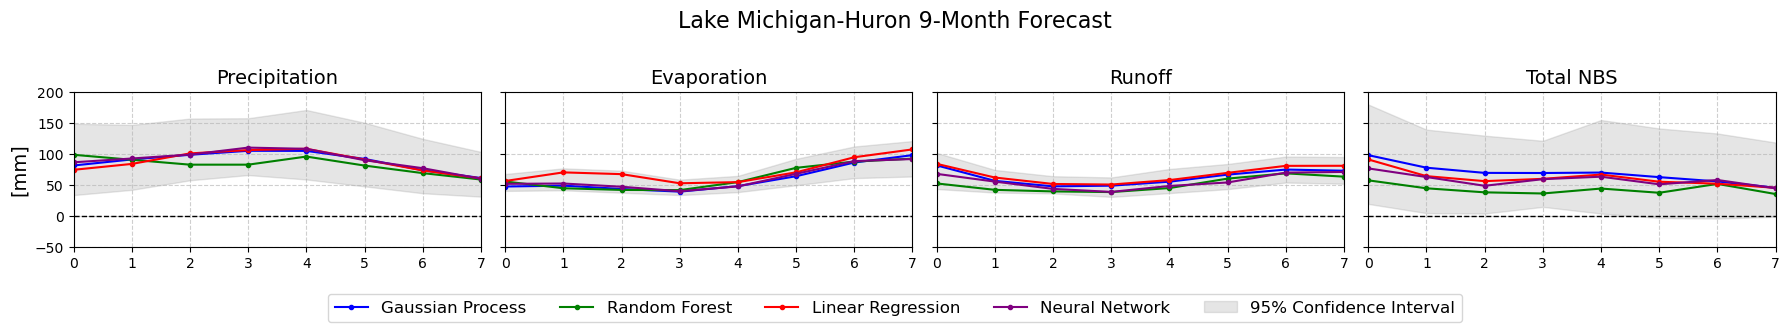

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

model_colors = {
    'GP': 'blue',
    'RF': 'green',
    'LR': 'red',
    'NN': 'purple'
}
model_legend = {
    'GP': 'Gaussian Process',
    'RF': 'Random Forest',
    'LR': 'Linear Regression',
    'NN': 'Neural Network'
}

# Mich-Huron variables only
columns = [
    'michigan-huron_precipitation',
    'michigan-huron_evaporation',
    'michigan-huron_runoff',
    'michigan-huron_cnbs'
]

# Create a 1x4 grid for the Mich-Huron row
fig, axs = plt.subplots(1, 4, figsize=(18, 3))

# Shared y-limits for columns 0–2, separate for column 3 (NBS)
shared_y_min, shared_y_max = float('inf'), float('-inf')
col4_y_min, col4_y_max = float('inf'), float('-inf')

for col, column in enumerate(columns):
    lower_bound = df.groupby(['year', 'month'])[column].quantile(0.025).reset_index()
    upper_bound = df.groupby(['year', 'month'])[column].quantile(0.975).reset_index()

    for model_info in models_info:
        model_name = model_info['model']
        model_mean = df[df['model'] == model_name]
        mean_df = model_mean.groupby(['year', 'month']).mean(numeric_only=True).reset_index()

        # Simulate forecast horizon as 0–7 months
        x_vals = np.arange(8)
        y_vals = mean_df[column].iloc[:8]
        y_lower = lower_bound[column].iloc[:8]
        y_upper = upper_bound[column].iloc[:8]

        axs[col].plot(x_vals, y_vals, marker='o', markersize=3,
                      color=model_colors[model_name], label=model_legend[model_name])
    axs[col].fill_between(x_vals, y_lower, y_upper, color='gray', alpha=0.2, label='95% Confidence Interval')
    axs[col].axhline(0, color='black', linestyle='--', linewidth=1)
    axs[col].grid(True, linestyle='--', alpha=0.6)
    axs[col].set_yticks(np.arange(-1000, 1000, 50))

    # Track y-limits
    current_y_min = lower_bound[column].min()
    current_y_max = upper_bound[column].max()

    if col < 3:
        shared_y_min = min(shared_y_min, current_y_min)
        shared_y_max = max(shared_y_max, current_y_max)
    else:
        col4_y_min = min(col4_y_min, current_y_min)
        col4_y_max = max(col4_y_max, current_y_max)

    # Titles
    axs[col].set_title(['Precipitation', 'Evaporation', 'Runoff', 'Total NBS'][col], fontsize=14)

    # X-axis formatting
    axs[col].set_xticks(x_vals)
    axs[col].set_xticklabels([str(i) for i in x_vals])

    # Y-axis labeling
    if col == 0:
        axs[col].set_ylabel('[mm]', fontsize=14)
    #elif col == 3:
    #    axs[col].set_ylabel('', fontsize=14)
    else:
        axs[col].set_yticklabels([])

# Apply y-limits
for col in range(4):
    axs[col].set_xlim(0, 7)
    if col < 3:
        axs[col].set_ylim(-50, 200)
    else:
        axs[col].set_ylim(-50, 200)

# X-axis label
#fig.text(0.5, 0.15, 'Months into the Future', ha='center', fontsize=12)
fig.suptitle('Lake Michigan-Huron 9-Month Forecast', fontsize=16, y=1.02)

# Combined legend at bottom
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),  # Further down than the x label
    ncol=len(labels),
    fontsize=12
)

# Adjust layout to leave enough room at the bottom for x-label and legend
plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig(f'{dir}forecast/CNBS_forecast_MichHuron_example.png')
plt.show()